In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jan  6 17:12:30 2018

@author: gcgibson
"""

import scipy.stats
import sys
import numpy as np
from numpy.random import random
import math
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

def observation_function(time_series_at_t,t,D,particle,params):
    
    tmp =  scipy.stats.poisson.pmf(time_series_at_t,np.exp(particle))
    if math.isnan(tmp):
        tmp = 0
    return tmp

def transition_function(particles,params):
    particles[:,0]  += np.random.normal(0,1,len(particles))
    return particles

def expected_value_observation_function(p):
    return np.exp(p)

def expected_value_transition_function(p):
    return p

def create_uniform_particles( N,state_space_dimension):
    particles  = np.random.normal(0,1 , size=(N,state_space_dimension))
    return particles

def predict(particles,t,params):
    particles = transition_function(particles,params)
    return particles


def update(particles, weights,ts,t,D,params):
    weights.fill(1.)
    for p in range(len(particles)):
        weights[p] *= observation_function(ts[t],t,D,particles[p],params)
    weights += 1.e-300
    return weights/sum(weights)  



def neff(weights):
    return 1. / np.sum(np.square(weights))


def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""
    pos = particles[:, 0]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

### VARIOUS RESAMPLING SCHEMES
def multinomal_resample(weights):
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1.  # avoid round-off errors
    return np.searchsorted(cumulative_sum, random(len(weights)))


def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill(1.0 / len(weights))
    return particles,weights

def stratified_resample(weights):
    N = len(weights)
    # make N subdivisions, chose a random position within each one
    positions = (random(N) + range(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)

    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes



def run_pf(time_series,N,state_space_dimension,D,params):
    
    particles = create_uniform_particles(N=N,state_space_dimension=state_space_dimension)
    weights = np.zeros(N)    
    xs = [] 
    ws = []
    ws.append(weights)
    for t in range(len(time_series)):
        particles = predict(particles,t,params)       
        # incorporate measurements
        weights = update(particles, weights,time_series, t, D, params)
        ws.append(weights)
        #print (neff(weights),time_series[t],params)
        indexes = stratified_resample(weights)
        particles,weights = resample_from_index(particles, weights, indexes)
        mu, var = estimate(particles, weights)
        xs.append(mu.tolist())
    return xs,particles,ws

 


"""
Suppose we are given data in the form 

n_{0,0} , n_{0,1} , n_{0,2}, n_{0,3}
n_{1,0} , n_{1,1} , n_{1,2}, 0
n_{2,0} , n_{2,1} , 0      , 0
n_{3,0} , 0       , 0      , 0

where T=3.

Now suppose D=2, then we truncate this matrix as follows

n_{0,0} , n_{0,1} , n_{0,2}, 0
n_{1,0} , n_{1,1} , n_{1,2}, 0
n_{2,0} , n_{2,1} , 0      , 0
n_{3,0} , 0       , 0      , 0


so for a setting of parameters (T=2,D=3) the reporting trapezoid is completely 
defined

In order to get the N_{t,T}s we simply add up the rows


"""
SIMULATE = False
D = 20
if SIMULATE == False:
    n_t_d = []
    with open("province-biweek_with_delays.csv") as f:
        i = 0
        for line in f.readlines():
            if i > 0:
                n_t_d.append(line.replace("\n","").split(','))
            i+=1
    date_to_index = {}
    
    i = 0
    for elm in n_t_d:
        if len(elm[1]) == 1:
            elm[1] = "0" + elm[1]
        date_to_index[elm[0]+elm[1]] = i
    
        i+=1
    
    d_to_i = {}
    i = 0
    iter_ =  date_to_index.keys()
    iter_.sort()
    for key in iter_:
    
        d_to_i[key] = i
        i+=1
    
    n_t = np.zeros((52-1,52-1))
    
    for elm in n_t_d:
        try:
            
            sick_date = d_to_i[elm[0]+elm[1]]
            report_date = d_to_i[elm[4] + elm[5]]
            if int(elm[4] + elm[5]) < 201621 and int(elm[3]) == 1:
                n_t[sick_date][report_date] += int(elm[3])
            
        except:
            pass
    
    
   
    
    n_t_d = []
    n_t_inf = []
    for row in range(len(n_t)):
        #if len(n_t[row][row:row+D]) == D:
            tmp = n_t[row][row:row+D].tolist()
            while len(tmp) < D:
                tmp += [0]
            n_t_d.append(tmp)
            n_t_inf.append(np.sum(n_t[row]))
    
    n_t_d = np.array(n_t_d)
    n_t_inf = np.array(n_t_inf)

else:
    true_p = [.1,.3,.2,.15,.15,.1]
    n_t_d = []
    n_t_inf = []
    states = []
    tmp = np.random.normal(4,1 ,1)
    states.append(tmp)
    n_t_inf.append(np.random.poisson(np.exp(tmp))[0])
    for i in range(1,10):
        tmp = np.random.normal(states[i-1],1,1)
        states.append(tmp)
        n_t_inf.append(np.random.poisson(np.exp(tmp))[0])
    for i in range(len(n_t_inf)):
        n_t_d.append(np.random.multinomial(n_t_inf[i],true_p).tolist())
        
    


total_mse_m1 = 0
total_mse_m2 = 0

print (n_t_d.shape)

## 51x10
print (n_t_inf.shape)

## 51

np.set_printoptions(threshold=np.nan)

#print (n_t_d)

(51, 20)
(51,)


In [3]:
n_t_inf = n_t_inf[:30]
n_t_d = n_t_d[:30]

In [4]:
count =D
fuck = []
for i in range(len(n_t_d)-D,len(n_t_d)):
    tmp = n_t_d[i][:D]
    tmp = tmp[:count] 
    fuck.append(tmp.tolist())
    count -=1

for row in range(len(fuck)):
    while len(fuck[row]) < D:
        fuck[row].append(0)
        
fuckme = np.append(n_t_d[:10],fuck,axis=0)

In [5]:
n_t_d = fuckme
tmp = n_t_inf[10:]  + np.random.poisson(20,size=D)
n_t_inf = np.append(n_t_inf[:10],tmp,axis=0)


In [6]:
print (n_t_inf)
print (n_t_d.sum(axis=1))

[11.  7. 16. 15. 25. 25. 21. 50. 51. 54. 71. 69. 64. 60. 48. 65. 59. 60.
 59. 58. 50. 44. 22. 19. 23. 24. 38. 38. 43. 50.]
[ 6.  6. 15. 15. 25. 25. 21. 50. 51. 54. 47. 46. 43. 39. 28. 40. 44. 42.
 43. 44. 36. 27.  7.  8.  6.  5.  0.  0.  0.  0.]


100%|██████████| 50500/50500 [00:11<00:00, 4532.07it/s]


Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
[8.257458349476945, 7.009802781653677, 15.9554119076316, 15.1180933810688, 24.610272522418647, 25.003662408776613, 23.209936246523398, 46.53501911781855, 49.11864639957311, 53.82975153779188, 68.28899378861003, 69.0, 60.0]


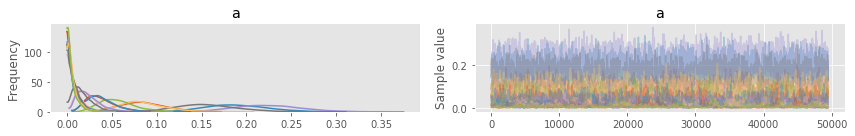

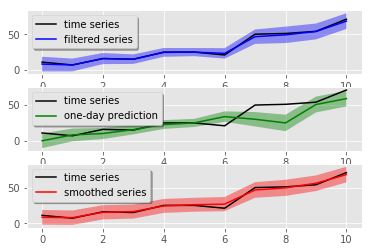

MSE ignoring delay
8431.156026953206
MSE delay adjusted
3164.6647532998163


SystemExit: 

In [13]:
import matplotlib.pyplot as plt




T =30
for tau in [T]:


    train_n_t_d = n_t_d[:tau-D + 1]
    train_n_t_inf = n_t_inf[:tau-D + 1]
    #print (test_n_t_inf.shape)
    count = D
    for t_prime in range(len(train_n_t_d)-D,len(train_n_t_d)):
        train_n_t_d[t_prime][count:] = 0
        count -=1
    
    test_n_t_d = n_t_d[tau- D + 1:tau ]
    test_n_t_inf = n_t_inf[tau-D +1:tau ]
    

    import numpy as np
    import pymc3 as pm
    import pandas as pd


    ## Delay Model

    DELAY_DIST = True
    if DELAY_DIST == True:

        k = np.array(train_n_t_d).shape[1 ]

        with pm.Model() as multinom_test:
            a = pm.Dirichlet('a', a=np.ones(k))
            for i in range(len(train_n_t_d)):
                data_pred = pm.Multinomial('data_pred_%s'% i, n=sum(train_n_t_d[i]), p=a, observed=train_n_t_d[i])
            trace = pm.sample(50000, pm.Metropolis())
            #trace = pm.sample(1000) # also works with NUTS

        pm.traceplot(trace[500:]);

    state_trajectories = []
    PF = False
    if  PF:
        N = 10000
        state_space_dimension = 1

        params = []
        means , particles, weights = run_pf(train_n_t_inf,N,state_space_dimension,D,params)



        ### Interval Predictions
        state_trajectories = [particles]
        observation_trajectories = [np.exp(particles)]
        for i in range(len(test_n_t_inf)):
            tmp = expected_value_transition_function(state_trajectories[i-1])
            observation_trajectories.append(expected_value_observation_function(tmp))
            state_trajectories.append(tmp) 

        state_trajectories = state_trajectories[1:]
        ## MEAN
        #print (np.mean(observation_trajectories,axis=1))
        ## QUANTILES 
        state_trajectories = np.array(state_trajectories).reshape((len(test_n_t_inf),-1))


    else:
        myDLM = dlm(train_n_t_inf)
        myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
        # add a 7 day seasonality with prior covariance 1.0
        myDLM = myDLM + seasonality(52, name='7day', w=1.0)
        # add a 3 step auto regression
        
        myDLM = myDLM + autoReg(degree=2, data=train_n_t_inf, name='ar3', w=1.0)
        myDLM.fit()
        br =  myDLM.getMean(filterType='forwardFilter')
        br.append(n_t_inf[len(br)])
        br.append(n_t_inf[len(br)+1])
        print (br)
        (predictMean, predictVar) = myDLM.predictN(N=len(test_n_t_inf), date=myDLM.n-1)

   


    for i in range(len(predictMean)):
        samples = np.random.normal(predictMean[i],np.sqrt(predictVar[i]),100)
        state_trajectories.append(samples)
    state_trajectories = np.array(state_trajectories)


    phat = trace['a'].mean(axis=0)
    from scipy.stats import binom



    myDLM.plot()

    ##compute weighted trajectories 

    weighted_trajectories = []
    for i in range(len(state_trajectories)):
        tmp = []
        samples = state_trajectories[i]
        row_sum = sum(test_n_t_d[i])
        q = sum(phat[:len(phat)-i-1])
        for samp in samples:
            btemp = binom.pmf(row_sum,samp,q)
            if np.isnan(btemp):
                tmp.append(0)
            else:
                tmp.append(btemp)
            #print (row_sum,samp,q,btemp)
        weighted_trajectories.append(tmp)
    weighted_trajectories = np.array(weighted_trajectories)

    
    for i in range(len(weighted_trajectories)):
        weighted_trajectories[i] = weighted_trajectories[i]/sum(weighted_trajectories[i])
    where_are_NaNs = np.isnan(weighted_trajectories)
    weighted_trajectories[where_are_NaNs] = 1e-50
    #print (weighted_trajectories)
    ###
    from sklearn.metrics import mean_squared_error



    max_indeces = np.argmax(weighted_trajectories,axis=1)
    max_point = []
    for i in range(len(max_indeces)):
        max_point.append(state_trajectories[i][max_indeces[i]])


    print "MSE ignoring delay"
    print (mean_squared_error(np.average(state_trajectories,axis=1),test_n_t_inf))
    total_mse_m1 += mean_squared_error(np.average(state_trajectories,axis=1),test_n_t_inf)
    print "MSE delay adjusted"
    print (mean_squared_error(np.average(state_trajectories,weights = weighted_trajectories,axis=1),test_n_t_inf))
    total_mse_m2 += mean_squared_error(np.average(state_trajectories,weights = weighted_trajectories,axis=1),test_n_t_inf)
    
    state_trajectories = state_trajectories[:12]
    weighted_trajectories = weighted_trajectories[:12]
    test_n_t_inf = test_n_t_inf[:12]
    plt.style.use('ggplot')
    #plt.figure(figsize=(12, 8))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(len(br)),br,color='red')
    ax.fill_between(range(len(br)),np.array(br)-5,np.array(br)+5,color='red',alpha=.2)
    ax.plot(range(len(br)),n_t_inf[:len(br)],color='black')
    ax.plot(range(len(br),len(br)+len(state_trajectories)),np.average(state_trajectories,axis=1),color='green')
    ax.fill_between(range(len(br),len(br)+len(state_trajectories)),np.average(state_trajectories,axis=1) - .7*np.arange(1,len(state_trajectories)+1),np.average(state_trajectories,axis=1) + .7*np.arange(1,len(state_trajectories)+1),color='green',alpha=.2)    
    
    
    ax.plot(range(len(br),len(br)+len(state_trajectories)),np.average(state_trajectories,weights = weighted_trajectories,axis=1),color='purple')
    ax.fill_between(range(len(br),len(br)+len(state_trajectories)),np.average(state_trajectories,weights = weighted_trajectories,axis=1) - .7*np.arange(1,len(state_trajectories)+1),np.average(state_trajectories,weights = weighted_trajectories,axis=1)+ .7*np.arange(1,len(state_trajectories)+1),color='purple',alpha=.2)    

    ax.set_xticks([])
    #plt.bar(range(len(state_trajectories)),test_n_t_d.sum(axis=1).tolist())
    #ax.xticks(np.arange(1, len(state_trajectories), 1.0))
    ax.legend(('Model Fit','Truth','12 Week Ahead Ignoring Delay','12 Week Ahead Delay Adjusted'))
    #plt.ylab("DHF Incidence")
    #plt.title('2006 Forecasts')
    txt = "2006 Forecasts"
   # plt.xlabel(r'\begin{center}X-axis\\*\textit{\small{' + txt + r'}}\end{center}')

    #plt.savefig('foo.png')

   # plt.show()
    
    sys.exit()
             

print "--------------\n\n\n"
print "MSE ignoring delay"
print (total_mse_m1)
print "MSE delay adjusted"
print (total_mse_m2)

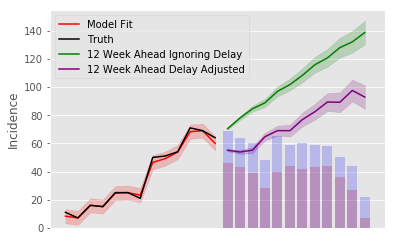

In [14]:

ax.bar(range(len(br),len(br)+len(test_n_t_d[:12])),test_n_t_d[:12].sum(axis=1).tolist(),alpha=.3)
ax.bar(range(len(br),len(br)+len(test_n_t_d[:12])),test_n_t_inf[:12].tolist(),alpha=.2,color='blue')

rects = ax.patches

# Make some labels.
labels = []
count = 12
# for i in range(13):
#     labels.append("N_" + str(i) + "_" + str(count - i))
# count = 0
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     if count % 2 == 0:
#         ax.text(rect.get_x() + rect.get_width() / 2, height -7, label,
#             ha='center', va='bottom',fontsize=6)
#     count +=1
    
plt.ylabel("Incidence")
#plt.xlabel("Week of 2006")
plt.savefig("ugggg")
plt.show()


In [41]:
print (len(test_n_t_d))
print (len(state_trajectories))

9
19


In [ ]:
n_t_d
